# **Principal Component Analysis (PCA) auf den MNIST Daten**
In diesem Notebook führen wir die PCA auf den Daten der MNIST Datenbank **Schritt für Schritt** durch.

Der MNIST (Modified National Institute of Standards) Datensatz ist ein Datensatz mit 70.000 Bildern von handgeschriebenen Ziffern. Dieser Datensatz wird weltweit als Standarddatensatz genutzt, um zu prüfen wie gut Machine Learning Verfahren die Bilderkennung beherrschen. Darüber hinaus zeigt es ein Anwendungbeispiel bei dem man mit herkömmlichen Programmiermethoden schnell an Grenzen stößt, das aber mit Künstlichen Neuronalen Netzen sehr gut lösbar ist.

## Vorbereitung

### **Daten laden und Überblick verschaffen**

In diesem Schritt werden zunächst alle Pakete geladen, die in diesem Notebook benötigt werden. Danach werden die Daten geladen.

#### Pakete laden

In [1]:
# Benötigte Pakete Laden
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# MNIST laden (nur 10000 Beispiele zur Vereinfachung)
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data[:10000]
y = mnist.target[:10000].astype(int)

#### Die Daten explorieren

In [2]:
# Überblick über die Daten verschaffen:
print("Datenform:", X.shape)
print("Label-Verteilung:", np.bincount(y))

Datenform: (10000, 784)
Label-Verteilung: [1001 1127  991 1032  980  863 1014 1070  944  978]


Die **Datenform** zeigt an, dass uns hier 10.000 Datensätzen in 784 Dimensionen vorliegen, was genau unseren 28 * 28 Pixeln entspricht.

Die **Label-Verteilung** gibt an, wie oft jede Ziffer (0 bis 9) im Datensatz vorkommt. (Also 1001 Bilder zeigen die Ziffer 0, 1127 die Ziffer 1 usw.)

#### Einen einzelnen Eintrag ansehen

In [3]:
# Einen einzelnen Datensatz ausgeben (1. Bild):
print("Pixelwerte von Bild 0:")
print(X.iloc[0].values)

Pixelwerte von Bild 0:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247

Ein einzelner Datensatz enthält also die Pixelweisen-Graustufenwerte des Bildes als Zahlen von 0-255.

#### Einzelne Einträge plotten

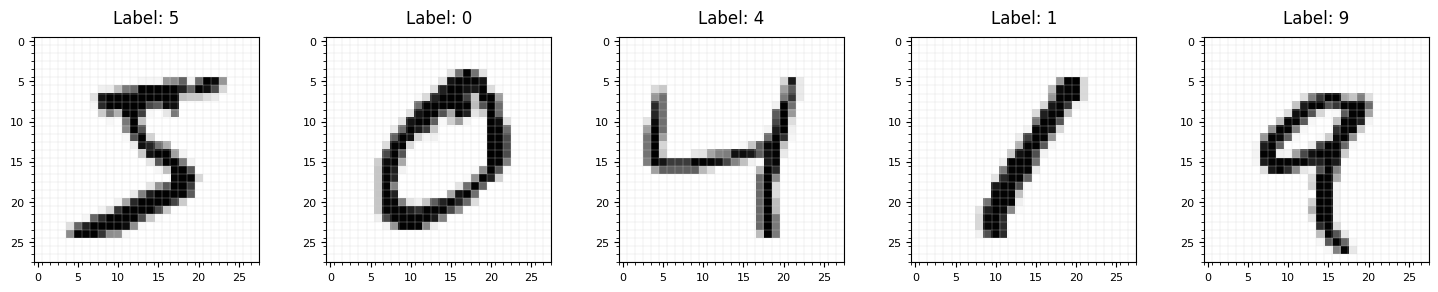

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4), gridspec_kw={'wspace': 0.3})

for i, ax in enumerate(axes):

    ax.imshow(
        X.iloc[i].values.reshape(28, 28),
        cmap='Greys', # Greys | gray
        interpolation='none',  # Scharfe Pixelgrenzen
        aspect='equal'         # Quadratische Pixel
    )

    ax.set_title(f"Label: {y[i]}", pad=10)

    # Gitterlinien zwischen allen Pixeln (fein und hellgrau)
    ax.set_xticks(np.arange(-0.5, 28, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 28, 1), minor=True)
    ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.3, alpha=0.7)

    # Achsen anzeigen (mit Beschriftung)
    ax.set_xticks(np.arange(0, 28, 5))  # Jede 5. X-Position beschriften
    ax.set_yticks(np.arange(0, 28, 5))  # Jede 5. Y-Position beschriften
    ax.tick_params(axis='both', labelsize=8)  # Kleinere Beschriftung

plt.show()

## **Principal Component Analysis**

### **Schritt 1:** Daten zentrieren

Bei diesen Daten liegen alle Variablen im gleichen Wertebereich von 0 bis 255. Da die Skalen aller Variablen bereits identisch sind, ist eine Standardisierung (Mittelwert=0, Varianz=1) nicht zwingend erforderlich. Allerdings müssen die Daten **zentriert** werden, d. h., der Mittelwert jeder Variable wird auf Null verschoben. Dies ist für die PCA essenziell, weil:

* Die PCA eine Eigenwertzerlegung der Kovarianzmatrix durchführt, die auf mittelwertzentrierten Daten basiert. Nur so misst die Kovarianzmatrix die tatsächliche gemeinsame Variation der Merkmale um ihren Mittelwert.

* Bei nicht zentrierten Daten würden die erste Hauptkomponente fälschlicherweise in Richtung des Mittelwerts der Originaldaten zeigen - und nicht in die Richtung maximaler Varianz.

In [5]:
## Die Daten standardisieren
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Die Daten zentrieren
mean_image = X.mean(axis=0)
mean_image = X.values.mean(axis=0)
X_scaled = X - mean_image

#### Wir schauen uns den Datensatz, den wir oben bereits ausgegeben haben, jetzt noch einmal an

In [6]:
# Zum Vergleich nochmal der vorherige Datensatz (1. Bild):
print("Zentrierte Pixelwerte von Bild 0:")

print(X_scaled.iloc[0].values.reshape(28, 28)) # Diese Zeile bei Zentrierung der Daten
#print(X_scaled[0].reshape(28, 28)) # Diese Zeile bei Verwendung von StandardScaler

Zentrierte Pixelwerte von Bild 0:
[[ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00 -1.020000e-02 -3.470000e-02 -5.550000e-02
  -5.760000e-02 -1.142000e-01 -1.070000e-01 -1.235000e-01 -1.085000e-01
  -1.389000e-01 -1.666000e-01 -1.116000e-01 -9.320000e-02 -8.250000e-02
  -7.890000e-02 -3.710000e-02 -2.830000e-02 -1.970000e-02  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -5.800000e-03
  -1.700000e-03 -5.100000e-03 -2.690000e-02 -1.912000e-01 -4.032000e-01
  -6.223000e

### **Schritt 2**: Kovarianz-Matrix, Eigenwerte und Eigenvektoren

#### Kovarianzmatrix

Die Kovarianzmatrix beschreibt die linearen Beziehungen zwischen den einzelnen Pixeln. Sie zeigt uns, wie stark zwei Pixel gemeinsam variieren, also ob sie tendenziell gleichzeitig hohe oder niedrige Werte annehmen.

In der PCA wird sie benötigt, um die Richtungen größter Varianz zu finden.

In [7]:
# Kovarianzmatrix berechnen
cov_matrix = np.cov(X_scaled.T)
print("Kovarianzmatrix-Form:", cov_matrix.shape)

Kovarianzmatrix-Form: (784, 784)


**Warum hat diese Kovarianzmatrix 784 × 784 Einträge?**

Die Kovarianzmatrix beschreibt die paarweisen linearen Beziehungen zwischen den Merkmalen (hier: Pixeln) eines Datensatzes. Für ein Bild mit 784 Pixeln ist sie eine symmetrische, quadratische Matrix der Größe 784×784, deren Einträge wie folgt definiert sind:

* Auf der Hauptdiagonalen stehen die Varianzen der einzelnen Pixel $(Cov(Xᵢ, Xᵢ) = Var(Xᵢ))$.
* Die Einträge oberhalb und unterhalb der Hauptdiagonalen entsprechen den Kovarianzen zwischen unterschiedlichen Pixeln $(Cov(Xᵢ, Xⱼ))$. Aufgrund der Symmetrie $(Cov(Xᵢ, Xⱼ) = Cov(Xⱼ, Xᵢ))$ sind die Werte spiegelsymmetrisch zur Hauptdiagonalen.

Damit erfasst die Matrix vollständig, wie stark die Intensitätswerte aller Pixelpaare gemeinsam variieren.

##### Heatmap

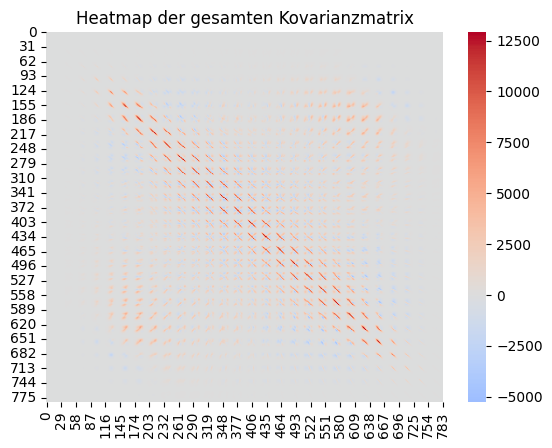

In [8]:
sns.heatmap(cov_matrix, cmap="coolwarm", center=0)
plt.title("Heatmap der gesamten Kovarianzmatrix")
plt.show()

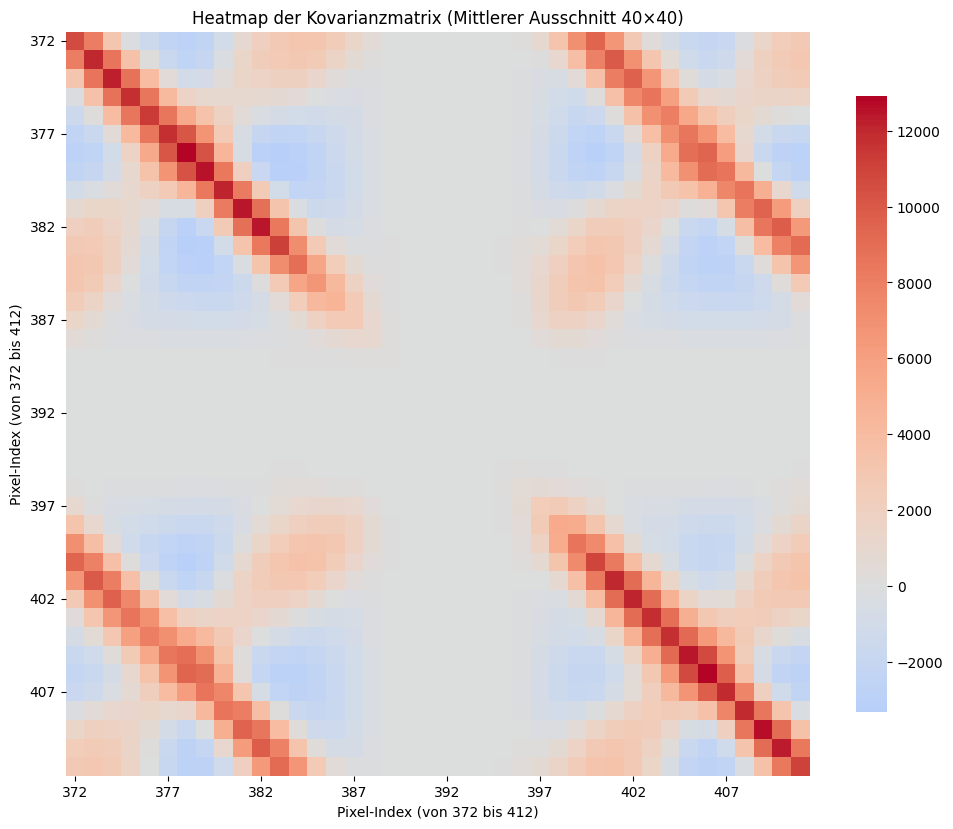

In [9]:
n = cov_matrix.shape[0]  # 784
center = n // 2          # 392
start = center - 20       # 372 (Startindex)
end = center + 20         # 412 (Endindex)

# Ausschnitt aus der Mitte
cov_snippet = cov_matrix[start:end, start:end]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cov_snippet,
    cmap="coolwarm",
    center=0,
    annot=False,
    square=True,
    cbar_kws={"shrink": 0.8}
)

# Titel und Achsenbeschriftungen
plt.title("Heatmap der Kovarianzmatrix (Mittlerer Ausschnitt 40×40)")
plt.xlabel("Pixel-Index (von {} bis {})".format(start, end))
plt.ylabel("Pixel-Index (von {} bis {})".format(start, end))

# Anpassung der Achsen: Tatsächliche Indizes + nur jedes 5. Label
xtick_positions = np.arange(0, end - start, 5) + 0.5  # Sprungweite 5
xtick_labels = np.arange(start, end, 5)         # Echte Indizes

plt.xticks(
    ticks=xtick_positions,
    labels=xtick_labels,
    rotation=0  # Keine Rotation für bessere Lesbarkeit
)

plt.yticks(
    ticks=xtick_positions,
    labels=xtick_labels,
    rotation=0
)

plt.show()

#### Eigenwerte und Eigenvektoren

Wir berechnen nun die **Eigenwerte** und **Eigenvektoren** der Kovarianzmatrix. Die Eigenwerte geben an, wie viel Varianz jeweils durch eine Hauptkomponente erklärt wird. Die Eigenvektoren sind die Richtungen dieser Hauptkomponenten.

Basierend auf der Kovarianzmatrix lassen sich die Eigenwerte und und Eigenvektoren berechnen. Diese helfen dabei, Richtungen mit der größten Varianz in den Daten zu identifizieren.

Die **Eigenvektoren** definieren die Richtungen der neuen Hauptkomponentenachsen im ursprünglichen Merkmalsraum. Jeder Eigenvektor zeigt in die **Richtung der maximalen Varianz** für die entsprechende Hauptkomponente.

Die **Elemente eines Eigenvektors** zeigen an, wie stark jede der ursprünglichen Variablen zu der neuen Hauptkomponente beiträgt. Wenn ein Element eines Eigenvektors groß ist, bedeutet dies, dass die entsprechende ursprüngliche Variable einen starken Einfluss auf diese Hauptkomponente hat.

Die **Eigenwerte** geben die Varianz der Daten entlang der neuen Hauptkomponentenachsen an. Ein großer Eigenwert zeigt an, dass die zugehörige Hauptkomponente eine große Menge an Varianz in den Daten erklärt.


In [10]:
# Eigenwerte und Eigenvektoren berechnen
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

Wir möchten die Eigenvektoren bzw. Hauptkomponenten identifizieren, die den größten Anteil an Varianz in den Daten erklären. Dazu sortieren wir die Eigenwerte nach absteigender größe.

In [11]:
# Eigenwerte absteigend sortieren
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

### **Schritt 3**: Ladungsmatrix

In [12]:
print("Eigenvektoren-Form:", eigenvectors.shape)

Eigenvektoren-Form: (784, 784)


Bei 784 Variablen / Dimensionen erhalten wie 784 Eigenvektoren bzw. Hauptkomponenten in 784 dimensionen. Wir könnten natürlich jetzt die LAdungs-Matrix anzeigen lassen. Diese wäre aber sehr groß, unübersichtlich und in etwa so gut zu interpretieren wie zuvor die Textausgabe eines einzelnen Bildes.
Da wir hier aber ja tatsächlich Bilder betrachten, können wir die Einzelnen Hauptkomponenten auch asl Bilder darstellen. Der Bezug zu den einzelnen Pixeln ist dann intuitiv gegeben.

#### Visualisierung der Hauptkomponenten

Die Hauptkomponenten lassen sich als 28×28 Pixel Heatmaps visualisieren. Diese Darstellung ermöglicht eine intuitive Interpretation:

* Positive Werte (rote Töne) zeigen Pixelbereiche, die stark positiv zum jeweiligen Hauptkomponentenvektor beitragen

* Negative Werte (blaue Töne) kennzeichnen Bereiche mit negativem Einfluss

* Werte nahe Null deuten auf Pixel hin, die für diese Hauptkomponente kaum (blassgraue Farben) oder gar nicht (grau) relevant sind.

Jede Heatmap entspricht somit einem Eigenvektor der Kovarianzmatrix und zeigt, wie die ursprünglichen Pixel in die neue Hauptkomponente transformiert werden.

Der Erste Plot hier zeigt die ersten 4 Hauptkomponenten

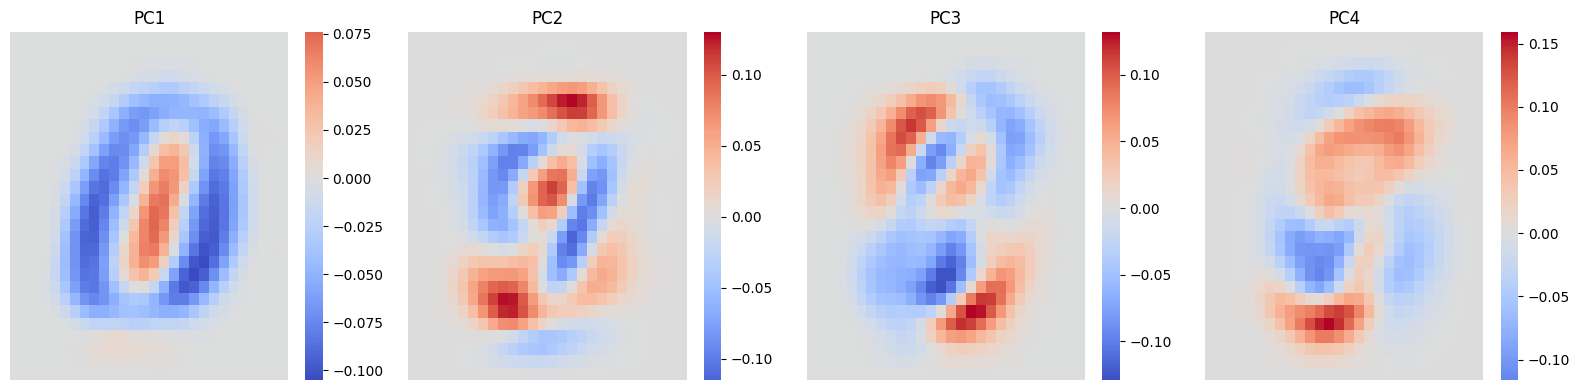

In [13]:
start_index =  0 # Definiert den index des ersten der vier PC's die angezeigt werden (aus 0-783)

plt.figure(figsize=(16, 4))

for i in range(4):
    # Holen Sie sich den (start_index + i)-ten Eigenvektor
    pc = eigenvectors[:, start_index + i].reshape(28, 28)

    # Erstellen Sie einen Subplot für jede Hauptkomponente
    plt.subplot(1, 4, i + 1)
    sns.heatmap(pc, cmap='coolwarm', center=0)
    plt.title(f"PC{start_index + i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Der folgende Plot zeigt die Hauptkomponenten, die nach der Sortierung nach der größe der zugehörigen Eigenwerte auf Platz 301 - 305 gelandet sind. Im Vergleich zu den ersten Hauptkomponenten haben diese schon deutlich weniger Struktur.

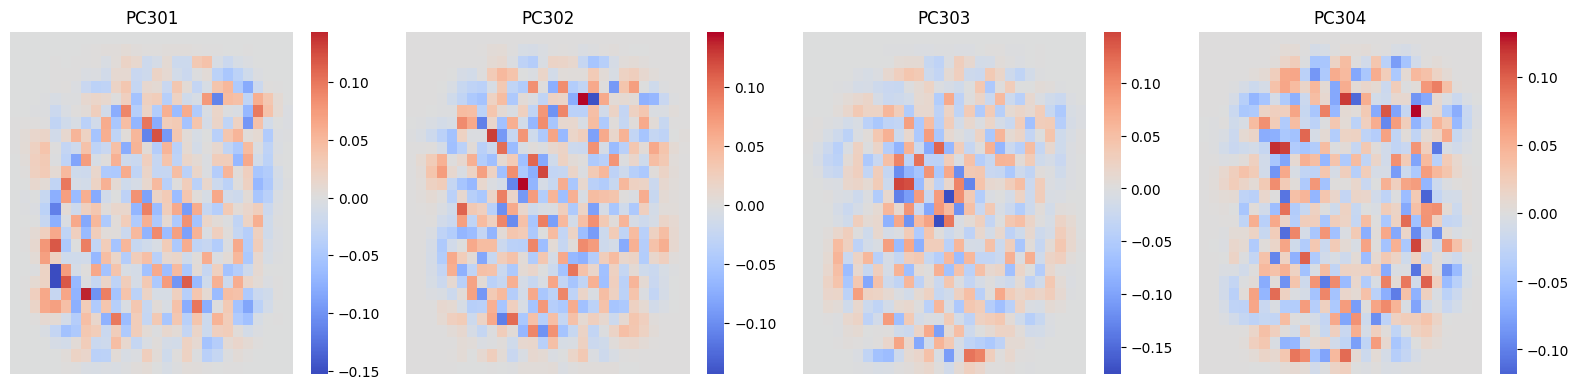

In [14]:
start_index =  300 # Definiert den index des ersten der vier PC's die angezeigt werden (aus 0-783)

plt.figure(figsize=(16, 4))

for i in range(4):
    # Holen Sie sich den (start_index + i)-ten Eigenvektor
    pc = eigenvectors[:, start_index + i].reshape(28, 28)

    # Erstellen Sie einen Subplot für jede Hauptkomponente
    plt.subplot(1, 4, i + 1)
    sns.heatmap(pc, cmap='coolwarm', center=0)
    plt.title(f"PC{start_index + i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### **Schritt 4**: Auswahl der Hauptkomponenten

Wenn die Hauptkomponenten bekannt sind, muss entschieden werden, wieviele davon herangezogen werden sollen um die Daten zu beschreiben. In diesem Schritt findet die eigentliche Dimesionsreduktion statt. Dabei muss berücksichtigt werden, dass mit der Dimensionsreduktion auch immer ein Informationsverlust einhergeht.

Ein zuverlässiges Kriterium ist die kumulierte Varianz. Dabei wird geschaut, wieviele Hauptkomponenten benötigt werden um 90% bzw 95% der Varianz in den Daten zu beschreiben.

#### Scree Plot

Ein Scree-Plot zeigt die Eigenwerte in absteigender Reihenfolge. So erkennt man, wie viel Varianz jede Komponente erklärt.

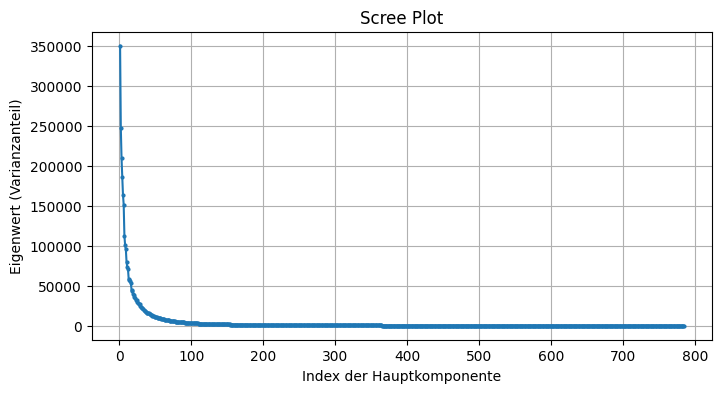

In [15]:
# Schritt 6: Scree-Plot und Auswahl der PCs
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, 785), eigenvalues[:784], 'o-',markersize=2)
plt.xlabel('Index der Hauptkomponente')
plt.ylabel('Eigenwert (Varianzanteil)')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

#### Kumulierte Varianz

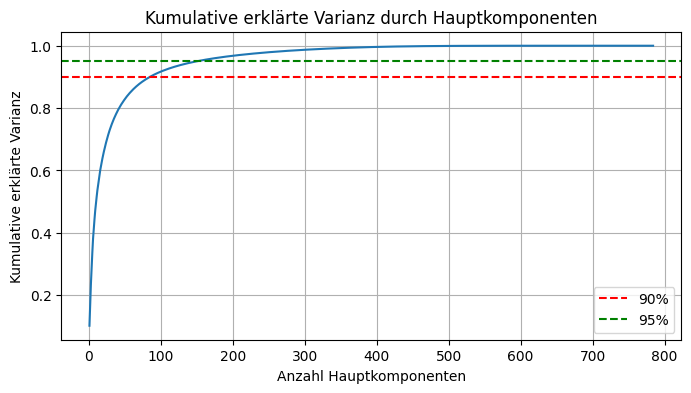

In [16]:
# Kumulierte erklärte Varianz berechnen
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot der kumulierten Varianz
plt.figure(figsize=(8, 4))

plt.plot(np.arange(1, len(cumulative_variance) + 1),
         cumulative_variance,
         linestyle='-',  # Durchgezogene Linie (Standard)
         linewidth=1.5   # Etwas dickere Linie für bessere Sichtbarkeit
)

plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.axhline(y=0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Anzahl Hauptkomponenten')
plt.ylabel('Kumulative erklärte Varianz')
plt.title('Kumulative erklärte Varianz durch Hauptkomponenten')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Komponentenanzahl für 90 % bzw. 95 % Varianz bestimmen
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Anzahl Komponenten für 90% erklärte Varianz: {n_90}")
print(f"Anzahl Komponenten für 95% erklärte Varianz: {n_95}")

Anzahl Komponenten für 90% erklärte Varianz: 85
Anzahl Komponenten für 95% erklärte Varianz: 150


Wir arbeiten im folgenden mit der Anzahl an Komponenten weiter, die benötigt werden um 95% der Varianz in den Daten zu beschreiben.

Anmerkung: Hier ist es interessant zu schauen, wie sich der Wert verändert wenn man die Daten standardisiert vs. zentriert.

### **Schritt 5**: Projektion der Daten

Die standardisierten Daten werden nun auf die gewählten Hauptkomponenten projiziert. Dadurch erhalten wir eine Darstellung der Daten in einem neuen Merkmalsraum mit reduzierter Dimensionalität. Mathematisch wird dies durch Matrixmultiplikation mit den ausgewählten Eigenvektoren umgesetzt.

In [18]:
num_components = n_95; # n_90 bei 90% erklaerter Varianz

X_pca = X_scaled.dot(eigenvectors[:, :num_components])
print("Projizierte Datenform:", X_pca.shape)


Projizierte Datenform: (10000, 150)


#### Projizierte Daten ausgeben

In [19]:
## Projizierte Daten ausgeben
print(pd.DataFrame(X_pca))

              0           1           2           3           4           5    \
0     -108.229105  336.867851   12.467063  526.756617  -39.040338  291.966665   
1    -1026.546772  381.932498 -535.279021  428.866239  802.456666  194.507059   
2       41.729643 -405.237670  263.831878 -456.081890  298.624114 -132.014390   
3      884.340937  568.873126 -201.426840 -113.794372  123.186448 -730.180981   
4      340.797660 -739.961313  -14.814271  247.543245 -113.318727  -29.497207   
...           ...         ...         ...         ...         ...         ...   
9995    43.868987  599.626206 -361.244107  943.920545   60.745721  365.235514   
9996   187.708010   27.234328  496.008968 -279.697123 -131.755876 -423.317492   
9997   485.476156  337.317859 -765.118035 -252.361240 -436.479726  303.934729   
9998   364.624558 -475.531718  425.751850  286.977327 -326.424867   75.774763   
9999   337.371377 -591.895267 -588.206216  486.743661  365.974550  -84.283919   

             6           7 

#### **Visualisierung der projizierten Daten**

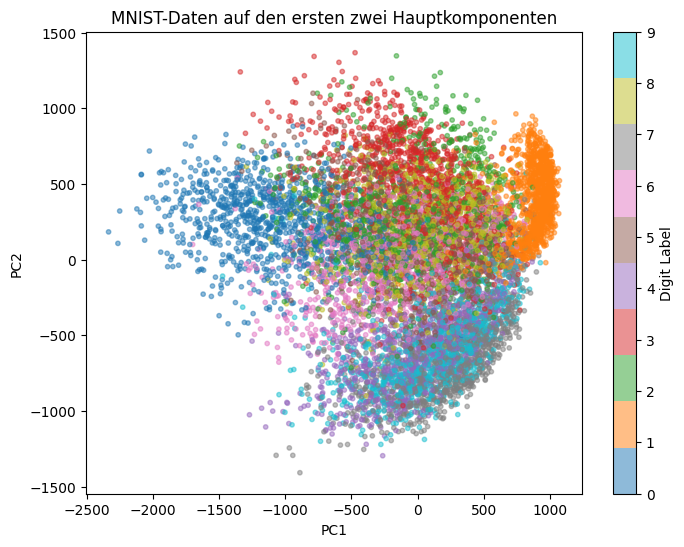

In [20]:
# Visualisierung der Daten entlang der ersten beiden PCs

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca.iloc[:, 0].values, X_pca.iloc[:, 1].values, c=y, cmap='tab10', alpha=0.5, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST-Daten auf den ersten zwei Hauptkomponenten")
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.show()

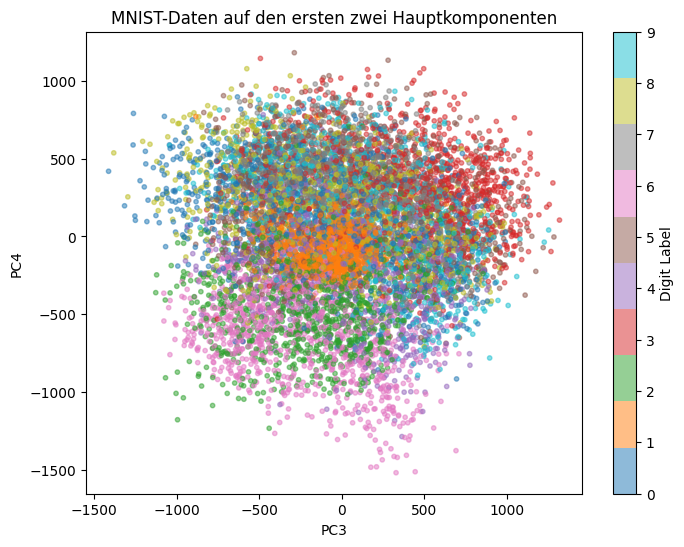

In [21]:
# Visualisierung der Daten entlang der 3. und 4. PC

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca.iloc[:, 2].values, X_pca.iloc[:, 3].values, c=y, cmap='tab10', alpha=0.5, s=10)
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("MNIST-Daten auf den ersten zwei Hauptkomponenten")
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.show()

## Rekonstruktion der Daten

In [22]:
W = eigenvectors[:, :num_components]
print(f"PCA Components Shape: {W.shape}")  # Sollte sein (anzahl variablen, num_components) = (784,150)

# Rückprojektion
X_reconstructed = X_pca @ W.T
print(f"Reconstructed Shape: {X_reconstructed.shape}")  # Sollte sein (n_samples, n_features) - also (10.000, 784)

PCA Components Shape: (784, 150)
Reconstructed Shape: (10000, 784)


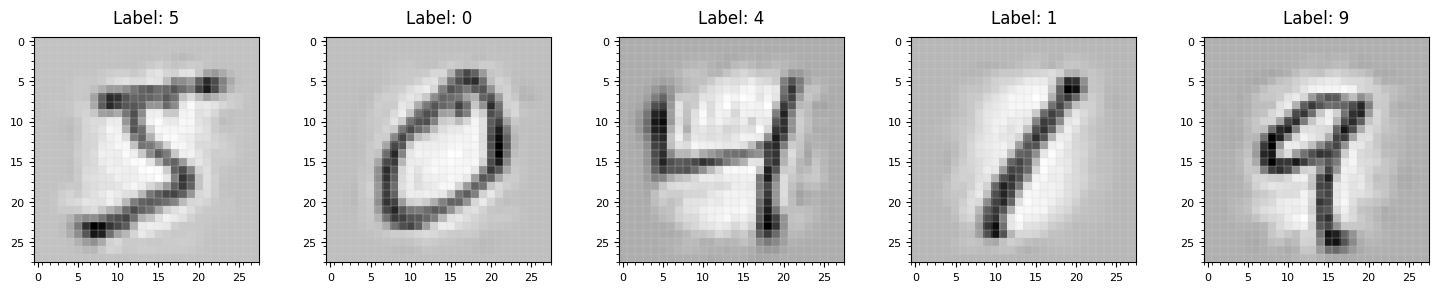

In [23]:
# Größere Abbildung für bessere Lesbarkeit
fig, axes = plt.subplots(1, 5, figsize=(18, 4), gridspec_kw={'wspace': 0.3})

for i, ax in enumerate(axes):

    ax.imshow(
        X_reconstructed.iloc[i].values.reshape(28, 28),
        cmap='Greys', # Greys | gray
        interpolation='none',  # Scharfe Pixelgrenzen
        aspect='equal'         # Quadratische Pixel
    )

    ax.set_title(f"Label: {y[i]}", pad=10)

    # Gitterlinien zwischen allen Pixeln (fein und hellgrau)
    ax.set_xticks(np.arange(-0.5, 28, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 28, 1), minor=True)
    ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.3, alpha=0.7)

    # Achsen anzeigen (mit Beschriftung)
    ax.set_xticks(np.arange(0, 28, 5))  # Jede 5. X-Position beschriften
    ax.set_yticks(np.arange(0, 28, 5))  # Jede 5. Y-Position beschriften
    ax.tick_params(axis='both', labelsize=8)  # Kleinere Beschriftung

plt.show()

In [24]:
# Rückgängigmachen der Zentrierung (Mittelwert wieder hinzufügen)
X_reconstructed = X_reconstructed + mean_image
print(f"Reconstructed Shape: {X_reconstructed.shape}")  # Sollte sein (n_samples, n_features) - also (10.000, 784)

Reconstructed Shape: (10000, 784)


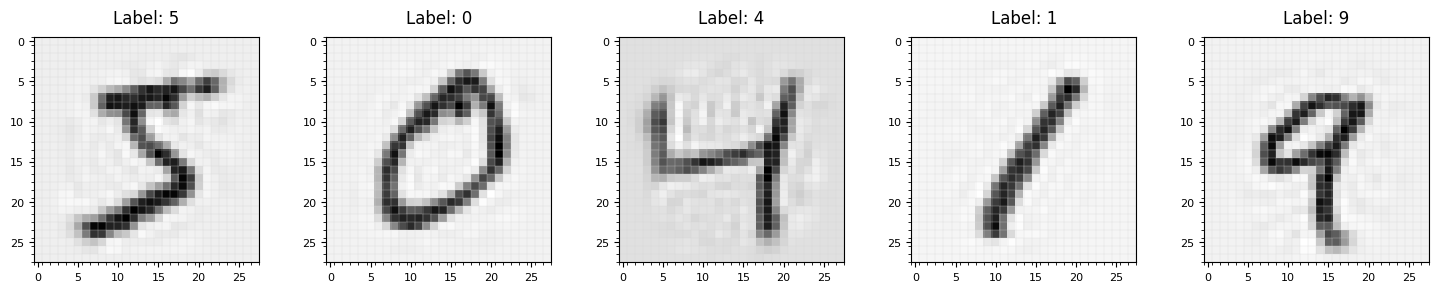

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4), gridspec_kw={'wspace': 0.3})

for i, ax in enumerate(axes):

    ax.imshow(
        X_reconstructed.iloc[i].values.reshape(28, 28),
        cmap='Greys', # Greys | gray
        interpolation='none',  # Scharfe Pixelgrenzen
        aspect='equal'         # Quadratische Pixel
    )

    ax.set_title(f"Label: {y[i]}", pad=10)

    # Gitterlinien zwischen allen Pixeln (fein und hellgrau)
    ax.set_xticks(np.arange(-0.5, 28, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 28, 1), minor=True)
    ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.3, alpha=0.7)

    # Achsen anzeigen (mit Beschriftung)
    ax.set_xticks(np.arange(0, 28, 5))  # Jede 5. X-Position beschriften
    ax.set_yticks(np.arange(0, 28, 5))  # Jede 5. Y-Position beschriften
    ax.tick_params(axis='both', labelsize=8)  # Kleinere Beschriftung

plt.show()